<a href="https://colab.research.google.com/github/sarwaridas/AdversarialPatches/blob/main/src/Adverserial_Patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# drive.mount('/gdrive')
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Final Project

/content/drive/MyDrive/Final Project


### Importing Required Packages

In [ ]:
import torch
import torchvision
from torch import nn
from torch.functional import F
from torch.optim import *
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'


### Writing the code for Resnet model

In [ ]:
# define the Resnet model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity = nn.Sequential()
        if stride != 1:
                self.identity = nn.Sequential(
                     nn.Conv2d(in_channels,out_channels, kernel_size=1, stride=stride),
                     nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        residual = self.identity(x)
        out += residual
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.layer(16, stride=1)
        self.layer2 = self.layer(32, stride=2)
        self.layer3 = self.layer(64, stride=2)
        self.linear = nn.Linear(64, 10)

    def layer(self, out_channels, stride):
      strides = [stride] + [1]*(2)
      layers = []
      for stride in strides:
            layers.append(Block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
      return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

### Loading pretrained resnet model

In [ ]:
model = ResNet()
model.load_state_dict(torch.load('resnet_91_98.ckpt'))
model = model.to(device)
model.eval()
print('model loaded and ready to run')

model loaded and ready to run


### loading data set and setting up train and test loader

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
    ])


batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Define Mean and STD for Train Data 

In [ ]:
NORM_MEAN = np.array([0.49139968, 0.48215827 ,0.44653124])
NORM_STD = np.array([0.24703233, 0.24348505, 0.26158768])

TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

### Plot the image

In [ ]:
def imshow(img):
    #img = (img * TENSOR_STD) + TENSOR_MEANS     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.title('Frog', fontsize=16)
    plt.show()

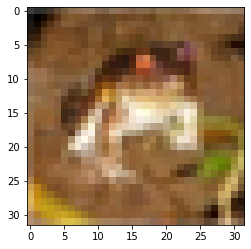

In [ ]:
imshow(next(iter(trainset))[0])

### This function will take a batch size and place a patch into each image 

In [ ]:
def place_patch(img, patch, angle):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch, angle)
    return img

### Normalize the patch into a valid image range. This is done before placing the image into the patch

In [ ]:
def patch_forward(patch, angle):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    patch = transforms.functional.rotate(img=patch, angle=angle)
    return patch

### The following function creates the targeted patch and evaluated the performance of that patch on the test data

In [ ]:
def create_targeted_patch(model, patch_size, target_class, testloader, angle):
  criterion = nn.CrossEntropyLoss()
  lr = 0.1
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = Adam([patch], lr = lr)

  for epoch in range(10):  # loop over the dataset multiple times

      # running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = place_patch(inputs, patch, angle)
          inputs = inputs.to(device)



          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          labels = labels.fill_(target_class)
          labels= labels.to(device)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

      total_examples = 0
      correct_examples = 0
      target_class_count = 0

      val_loss = 0 # again, track the validation loss if you want

      # disable gradient during validation, which can save GPU memory
      with torch.no_grad():
          for batch_idx, (inputs, labels) in enumerate(testloader):
              ####################################
              # copy inputs to device
              inputs = place_patch(inputs, patch, angle)
              inputs = inputs.to(device)
              labels = labels.to(device)

              
              # compute the output and loss
              outputs=model(inputs)

              
              # count the number of correctly predicted samples in the current batch
              _, predicted = torch.max(outputs, 1)
              target_class_count += sum(predicted == target_class).item()
              total_examples += labels.size(0)
              correct_examples += (predicted == labels).sum().item()
              ####################################

      avg_acc = correct_examples / total_examples
      print("Validation accuracy: %.4f" % (avg_acc))
      print('total target class count', target_class_count)




  print('Finished Training')
  return patch

### Define a dictionary for target classes and patch size list

In [ ]:
classes_dict =   {0: 'plane', 
                  1: 'car', 
                  2: 'bird', 
                  3: 'cat', 
                  4: 'deer', 
                  5: 'dog', 
                  6: 'frog', 
                  7: 'horse', 
                  8: 'ship', 
                  9: 'truck'}

patch_size = [3,5,7,16]


### Loading the model and using to create patches and saving those patches

In [ ]:
model = ResNet()
model.load_state_dict(torch.load('resnet_91_98.ckpt'))
model = model.to(device)
model.eval()
print('model loaded and ready to run')

for i in classes_dict:
  if i in {0,1,2,9}:
    for patch in patch_size:
      if patch == 16:
        patch_path = classes_dict[i] + str(patch) + 'x' + str(patch) + '.pt'
        print('Generating patch for class ', classes_dict[i], ' for patch size ', str(patch), '.')
        label_patch = create_targeted_patch(model, patch, i, testloader)
        torch.save(label_patch, patch_path)

model loaded and ready to run
Generating patch for class  plane  for patch size  16 .
Validation accuracy: 0.3148
total target class count 6379
Validation accuracy: 0.3005
total target class count 6724
Validation accuracy: 0.2854
total target class count 6990
Validation accuracy: 0.2749
total target class count 7208
Validation accuracy: 0.2756
total target class count 7313
Validation accuracy: 0.2719
total target class count 7389
Validation accuracy: 0.2687
total target class count 7409
Validation accuracy: 0.2595
total target class count 7613
Validation accuracy: 0.2526
total target class count 7696
Validation accuracy: 0.2538
total target class count 7704
Finished Training
Generating patch for class  car  for patch size  16 .
Validation accuracy: 0.2074
total target class count 8505
Validation accuracy: 0.1906
total target class count 8785
Validation accuracy: 0.1816
total target class count 8926
Validation accuracy: 0.1776
total target class count 9020
Validation accuracy: 0.1693
to

### Create rotated patches

In [ ]:
model = ResNet()
model.load_state_dict(torch.load('resnet_91_98.ckpt'))
model = model.to(device)
model.eval()
print('model loaded and ready to run')

rotations = [90, 180, 270]
for patch in patch_size:
    for rot in rotations:
        patch_path = "plane" + str(patch) + "x" + str(patch) + "rotate" + str(rot) + ".pt"
        print('Generating patch for patch size ', str(patch), ' rotation ', str(rot), '.')
        label_patch = create_targeted_patch(model, patch, 0, testloader, rot)
        torch.save(label_patch, patch_path)

model loaded and ready to run
Generating patch for patch size  7  rotation  90 .
Validation accuracy: 0.7756
total target class count 1713
Validation accuracy: 0.7650
total target class count 1827
Validation accuracy: 0.7669
total target class count 1845
Validation accuracy: 0.7600
total target class count 1905
Validation accuracy: 0.7602
total target class count 1904
Validation accuracy: 0.7619
total target class count 1860
Validation accuracy: 0.7639
total target class count 1885
Validation accuracy: 0.7648
total target class count 1879
Validation accuracy: 0.7602
total target class count 1895
Validation accuracy: 0.7620
total target class count 1853
Finished Training
Generating patch for patch size  7  rotation  180 .
Validation accuracy: 0.7734
total target class count 1722
Validation accuracy: 0.7714
total target class count 1783
Validation accuracy: 0.7720
total target class count 1803
Validation accuracy: 0.7661
total target class count 1808
Validation accuracy: 0.7662
total tar

### The function creates an untargeted patch and evaluates that patch on test loader

In [ ]:
def create_untargeted_patch(model, patch_size, testloader, angle):
  criterion = nn.CrossEntropyLoss()
  lr = 0.1
  patch = nn.Parameter(torch.rand(3, patch_size, patch_size), requires_grad=True)
  optimizer = Adam([patch], lr = lr)

  for epoch in range(10):  # loop over the dataset multiple times

      # running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = place_patch(inputs, patch, angle)
          inputs = inputs.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          labels= labels.to(device)
          loss = criterion(outputs, labels) * -1
          loss.backward()
          optimizer.step()

      total_examples = 0
      correct_examples = 0


      # disable gradient during validation, which can save GPU memory
      with torch.no_grad():
          for batch_idx, (inputs, labels) in enumerate(testloader):
              ####################################
              # copy inputs to device
              inputs = place_patch(inputs, patch, angle)
              inputs = inputs.to(device)
              labels = labels.to(device)

              
              # compute the output and loss
              outputs=model(inputs)

              
              # count the number of correctly predicted samples in the current batch
              _, predicted = torch.max(outputs, 1)
              total_examples += labels.size(0)
              correct_examples += (predicted == labels).sum().item()
              ####################################

      avg_acc = correct_examples / total_examples
      print("Validation accuracy: %.4f" % (avg_acc))

  print('Finished Training')
  return patch

In [ ]:
untargeted_patch = create_untargeted_patch(model, 16, testloader)
torch.save(untargeted_patch, 'untargeted' + str(16)+ 'x' + str(16) +'.pt')

Validation accuracy: 0.1003
Validation accuracy: 0.1002
Validation accuracy: 0.1001
Validation accuracy: 0.1000
Validation accuracy: 0.1000
Validation accuracy: 0.1000
Validation accuracy: 0.1000
Validation accuracy: 0.1000
Validation accuracy: 0.1001
Validation accuracy: 0.1001
Finished Training


### Rotate untargeted patch

In [ ]:
rotations = [90, 180, 270]
for patch in patch_size:
    for rot in rotations:
        patch_path = "untargeted" + str(patch) + "x" + str(patch) + "rotate" + str(rot) + ".pt"
        print('Generating patch for patch size ', str(patch), ' rotation ', str(rot), '.')
        untargeted_patch = create_untargeted_patch(model, patch, testloader, rot)
        torch.save(untargeted_patch, patch_path)

Generating patch for patch size  3  rotation  90 .
Validation accuracy: 0.8226
Validation accuracy: 0.8185
Validation accuracy: 0.8184
Validation accuracy: 0.8194
Validation accuracy: 0.8158
Validation accuracy: 0.8205
Validation accuracy: 0.8172
Validation accuracy: 0.8208
Validation accuracy: 0.8195
Validation accuracy: 0.8209
Finished Training
Generating patch for patch size  3  rotation  180 .
Validation accuracy: 0.8240
Validation accuracy: 0.8312
Validation accuracy: 0.8274
Validation accuracy: 0.8287
Validation accuracy: 0.8287
Validation accuracy: 0.8325
Validation accuracy: 0.8250
Validation accuracy: 0.8257
Validation accuracy: 0.8281
Validation accuracy: 0.8324
Finished Training
Generating patch for patch size  3  rotation  270 .
Validation accuracy: 0.8289
Validation accuracy: 0.8318
Validation accuracy: 0.8328
Validation accuracy: 0.8330
Validation accuracy: 0.8273
Validation accuracy: 0.8331
Validation accuracy: 0.8353
Validation accuracy: 0.8320
Validation accuracy: 0.83

### Plotting patches of the size 16x16

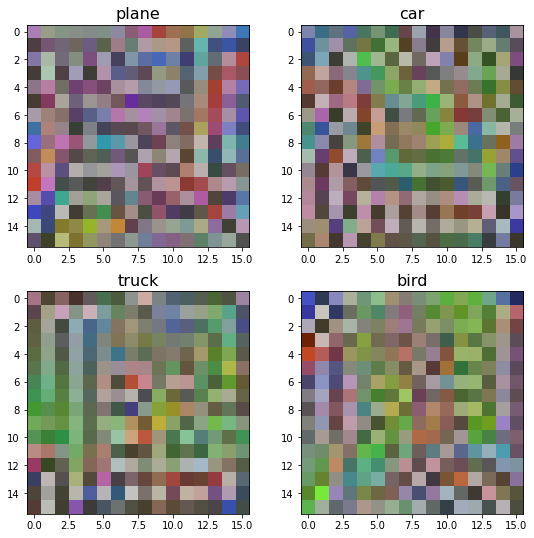

In [ ]:
patch_names = ['plane', 'car', 'truck', 'bird']
plt.subplots(2,2, figsize=(9,9))
for i in range(len(patch_names)):
  patch = torch.load(patch_names[i]+'16x16.pt')
  patch = (patch * TENSOR_STD) + TENSOR_MEANS
  patch = patch.detach().numpy().transpose(1,2,0)
  plt.subplot(2,2,i+1)
  plt.imshow(patch)
  plt.title(patch_names[i], fontsize=16)

### Plotting untargetted patch

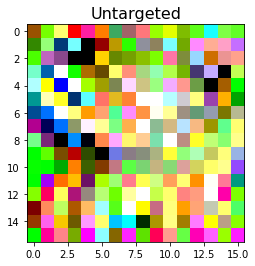

In [ ]:
patch = torch.load('untargeted16x16.pt')
patch = (patch * TENSOR_STD) + TENSOR_MEANS
patch = patch.detach().numpy().transpose(1,2,0)
plt.imshow(patch)
plt.title('Untargeted', fontsize= 16)
plt.show()

#### Patch testing on white box model (Resnet)

In [ ]:
patch_names = {'plane':0, 'car':1, 'truck':9, 'bird':2, 'untargeted': 10}
sizes = [3,5,7,16]
angle = 0

for i in patch_names:
  for j in sizes:
    patch = torch.load(i + str(j) + 'x' + str(j) + '.pt')
    total_examples = 0
    correct_examples = 0
    target_class_count = 0


    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
      for batch_idx, (inputs, labels) in enumerate(testloader):
        ####################################
        # copy inputs to device
        inputs = place_patch(inputs, patch, angle)
        inputs = inputs.to(device)
        labels = labels.to(device)

        
        # compute the output and loss
        outputs=model(inputs)

        
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        total_examples += labels.size(0)
        correct_examples += (predicted == labels).sum().item()
        if i != 'untargeted':
          target_class_count += sum(predicted == patch_names[i]).item()
        else:
          pass

      if i != 'untargeted':
        print('For the patch ', i, ' and size ', j, ' the accuracy on test data is ', correct_examples/total_examples, ' and the attack sucess rate is ', target_class_count/10_000)
      else:
        print('For the untargeted patch', ' of size ', j, ' the accuracy on test data is ', correct_examples/total_examples)




For the patch  plane  and size  3  the accuracy on test data is  0.8643  and the attack sucess rate is  0.1176
For the patch  plane  and size  5  the accuracy on test data is  0.8061  and the attack sucess rate is  0.1498
For the patch  plane  and size  7  the accuracy on test data is  0.7535  and the attack sucess rate is  0.1915
For the patch  plane  and size  16  the accuracy on test data is  0.2532  and the attack sucess rate is  0.7746
For the patch  car  and size  3  the accuracy on test data is  0.8874  and the attack sucess rate is  0.0965
For the patch  car  and size  5  the accuracy on test data is  0.8435  and the attack sucess rate is  0.1059
For the patch  car  and size  7  the accuracy on test data is  0.7391  and the attack sucess rate is  0.1699
For the patch  car  and size  16  the accuracy on test data is  0.1514  and the attack sucess rate is  0.9364
For the patch  truck  and size  3  the accuracy on test data is  0.8844  and the attack sucess rate is  0.1007
For the

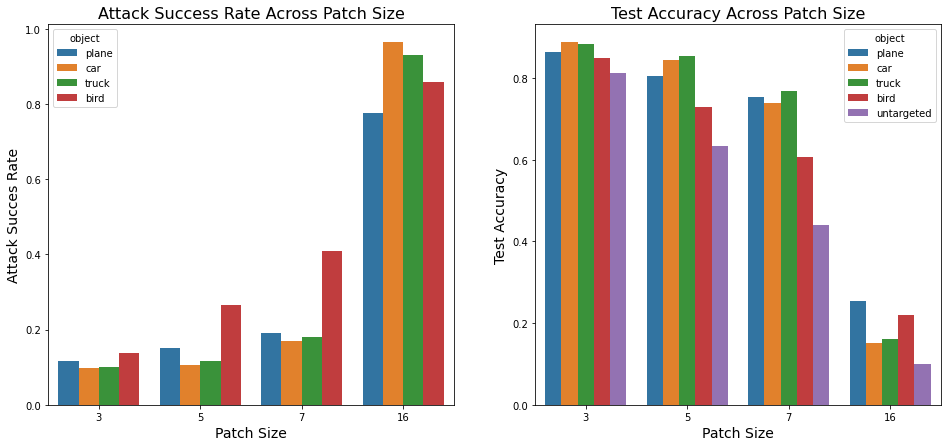

In [ ]:
patch = [3,5,7,16, 3,5,7,16, 3,5,7,16, 3,5,7,16, 3,5,7,16]
obj = ['plane', 'plane', 'plane', 'plane', 'car', 'car', 'car', 'car', 'truck', 'truck', 'truck', 'truck', 'bird', 'bird', 'bird', 'bird', 'untargeted', 'untargeted', 'untargeted', 'untargeted']
acc = [0.8643, 0.8061, 0.7535, 0.2532, 0.8874, 0.8435, 0.7391, 0.1514, 0.8844, 0.8539, 0.7685, 0.1606, 0.8488, 0.7284, 0.6076, 0.2194, 0.8127, 0.6336, 0.4411, 0.1009]
ATR = [0.1176, 0.1498, 0.1915, 0.7746, 0.0965, 0.1059, 0.1699, 0.9634, 0.1007, 0.116, 0.1811, 0.9309, 0.1377, 0.2648, 0.4093, 0.858, None, None, None, None]
#car_acc = [0.8874, 0.8435, 0.7391, 0.1514]
#car_ATR = [0.0965, 0.1059, 0.1699, 0.9634]
#truck_acc = [0.8844, 0.8539, 0.7685, 0.1606]
#truck_ATR = [0.1007, 0.116, 0.1811, 0.9309]
#bird_acc = [0.8488, 0.7284, 0.6076, 0.2194]
#bird_ATR = [0.1377, 0.2648, 0.4093, 0.858]
#untargeted_acc = [0.8127, 0.6336, 0.4411, 0.1009]

import pandas as pd
import seaborn as sns
data = pd.DataFrame({'patch': patch, 'object': obj, 'acc': acc, 'ATR' : ATR})
target = data.loc[data['object'] != 'untargeted']

plt.subplots(1,2, figsize=(16,7))
plt.subplot(1,2,1)
sns.barplot(data=target, x='patch', y ='ATR', hue='object')
plt.title('Attack Success Rate Across Patch Size', fontsize=16)
plt.ylabel('Attack Succes Rate', fontsize=14)
plt.xlabel('Patch Size', fontsize=14)

plt.subplot(1,2,2)
sns.barplot(data=data, x='patch', y ='acc', hue='object')
plt.title('Test Accuracy Across Patch Size', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=14)
plt.xlabel('Patch Size', fontsize=14)
plt.show()


### Test rotated patches

In [ ]:
sizes = [3,5,7,16]
rot = [0, 90, 180, 270]
rot_acc = []
rot_asr = []

for i in sizes:
    for j in rot:
        if j == 0:
            patch = torch.load('plane' + str(i) + 'x' + str(i) + '.pt')
        else:
            patch = torch.load('plane' + str(i) + 'x' + str(i) + 'rotate' + str(j) + '.pt')
        total_examples = 0
        correct_examples = 0
        target_class_count = 0


    # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
        ####################################
        # copy inputs to device
                inputs = place_patch(inputs, patch, j)
                inputs = inputs.to(device)
                labels = labels.to(device)

        
        # compute the output and loss
                outputs=model(inputs)

        
        # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                total_examples += labels.size(0)
                correct_examples += (predicted == labels).sum().item()
                if i != 'untargeted':
                    target_class_count += sum(predicted == 0).item()
                else:
                    pass

            if i != 'untargeted':
                print('For the patch size ', i, ' and rotation ', j, ' the accuracy on test data is ', correct_examples/total_examples, ' and the attack sucess rate is ', target_class_count/10_000)
            else:
                print('For the untargeted patch', ' of size ', j, ' the accuracy on test data is ', correct_examples/total_examples)
            rot_acc.append(correct_examples/total_examples)
            rot_asr.append(target_class_count/10_000)







For the patch size  3  and rotation  0  the accuracy on test data is  0.8666  and the attack sucess rate is  0.1174
For the patch size  3  and rotation  90  the accuracy on test data is  0.8654  and the attack sucess rate is  0.1156
For the patch size  3  and rotation  180  the accuracy on test data is  0.8585  and the attack sucess rate is  0.1178
For the patch size  3  and rotation  270  the accuracy on test data is  0.8501  and the attack sucess rate is  0.1226
For the patch size  5  and rotation  0  the accuracy on test data is  0.807  and the attack sucess rate is  0.1512
For the patch size  5  and rotation  90  the accuracy on test data is  0.8107  and the attack sucess rate is  0.1477
For the patch size  5  and rotation  180  the accuracy on test data is  0.8086  and the attack sucess rate is  0.1489
For the patch size  5  and rotation  270  the accuracy on test data is  0.8079  and the attack sucess rate is  0.1504
For the patch size  7  and rotation  0  the accuracy on test da

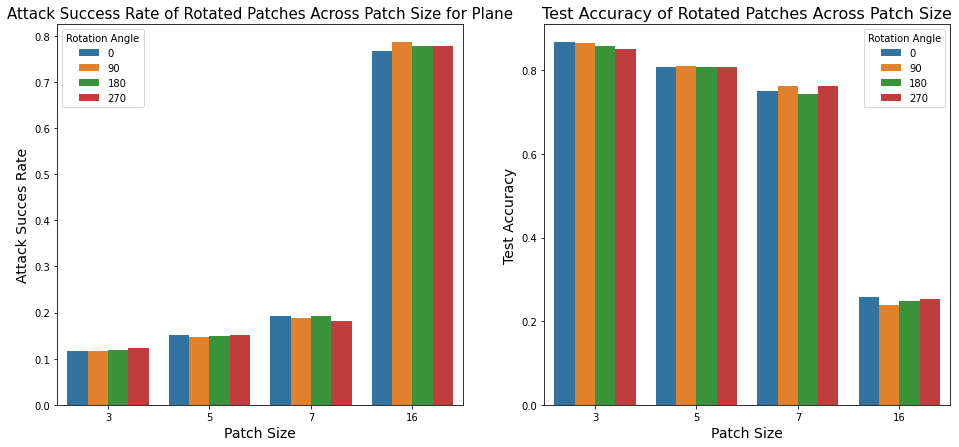

In [ ]:
rot_data = pd.DataFrame({
    "dim": [3, 3, 3, 3, 5, 5, 5, 5, 7, 7, 7, 7, 16, 16, 16, 16],
    "rot": [0, 90, 180, 270, 0, 90, 180, 270, 0, 90, 180, 270, 0, 90, 180, 270],
    "acc": rot_acc,
    "asr": rot_asr
})

plt.subplots(1,2, figsize=(16,7))
plt.subplot(1,2,1)
sns.barplot(data=rot_data, x='dim', y ='asr', hue='rot')
plt.title('Attack Success Rate of Rotated Patches Across Patch Size for Plane', fontsize=15)
plt.ylabel('Attack Succes Rate', fontsize=14)
plt.xlabel('Patch Size', fontsize=14)
plt.legend(title="Rotation Angle")

plt.subplot(1,2,2)
sns.barplot(data=rot_data, x='dim', y ='acc', hue='rot')
plt.title('Test Accuracy of Rotated Patches Across Patch Size', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=14)
plt.xlabel('Patch Size', fontsize=14)
plt.legend(title="Rotation Angle")
plt.show()

In [ ]:
sizes = [3,5,7,16]
rot = [0, 90, 180, 270]
untargeted_rot_acc = []
untargeted_rot_asr = []

for i in sizes:
    for j in rot:
        if j == 0:
            patch = torch.load('untargeted' + str(i) + 'x' + str(i) + '.pt')
        else:
            patch = torch.load('untargeted' + str(i) + 'x' + str(i) + 'rotate' + str(j) + '.pt')
        total_examples = 0
        correct_examples = 0
        target_class_count = 0


    # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
        ####################################
        # copy inputs to device
                inputs = place_patch(inputs, patch, j)
                inputs = inputs.to(device)
                labels = labels.to(device)

        
        # compute the output and loss
                outputs=model(inputs)

        
        # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                total_examples += labels.size(0)
                correct_examples += (predicted == labels).sum().item()
                if i != 'untargeted':
                    target_class_count += sum(predicted == 0).item()
                else:
                    pass

            if i != 'untargeted':
                print('For the patch size ', i, ' and rotation ', j, ' the accuracy on test data is ', correct_examples/total_examples, ' and the attack sucess rate is ', target_class_count/10_000)
            else:
                print('For the untargeted patch', ' of size ', j, ' the accuracy on test data is ', correct_examples/total_examples)
            untargeted_rot_acc.append(correct_examples/total_examples)
            untargeted_rot_asr.append(target_class_count/10_000)







For the patch size  3  and rotation  0  the accuracy on test data is  0.8154  and the attack sucess rate is  0.116
For the patch size  3  and rotation  90  the accuracy on test data is  0.823  and the attack sucess rate is  0.121
For the patch size  3  and rotation  180  the accuracy on test data is  0.8291  and the attack sucess rate is  0.1165
For the patch size  3  and rotation  270  the accuracy on test data is  0.8223  and the attack sucess rate is  0.1213
For the patch size  5  and rotation  0  the accuracy on test data is  0.6385  and the attack sucess rate is  0.0975
For the patch size  5  and rotation  90  the accuracy on test data is  0.6563  and the attack sucess rate is  0.1027
For the patch size  5  and rotation  180  the accuracy on test data is  0.672  and the attack sucess rate is  0.1057
For the patch size  5  and rotation  270  the accuracy on test data is  0.6546  and the attack sucess rate is  0.0985
For the patch size  7  and rotation  0  the accuracy on test data 

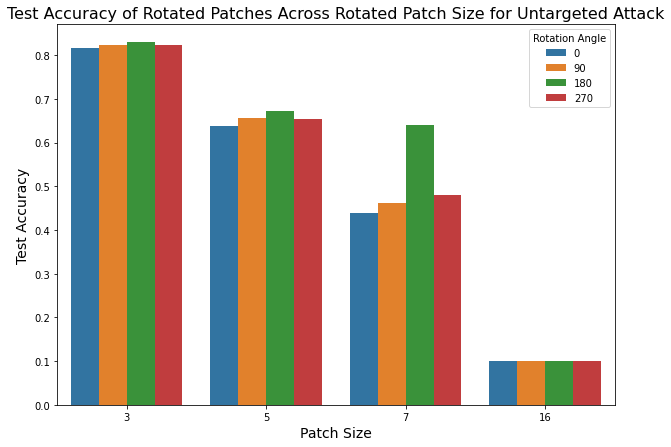

In [ ]:
untargeted_rot_data = pd.DataFrame({
    "dim": [3, 3, 3, 3, 5, 5, 5, 5, 7, 7, 7, 7, 16, 16, 16, 16],
    "rot": [0, 90, 180, 270, 0, 90, 180, 270, 0, 90, 180, 270, 0, 90, 180, 270],
    "acc": untargeted_rot_acc
})

plt.figure(figsize=(10, 7))
sns.barplot(data=untargeted_rot_data, x='dim', y ='acc', hue='rot')
plt.title('Test Accuracy of Rotated Patches Across Rotated Patch Size for Untargeted Attack', fontsize=16)
plt.legend(title="Rotation Angle")
plt.ylabel('Test Accuracy', fontsize=14)
plt.xlabel('Patch Size', fontsize=14)
plt.show()